# Multimodal Network

Create GNN for each of the dimensions and later combine them into a single network.

1. Each dimension is a separate graph and gets its own GNN.
2. Dimensions are connected in a MLP layer.

#### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import country_converter as coco
import functools
import os
from torchmetrics.regression import MeanAbsolutePercentageError


# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.chdir('/home/jovyan/dlss-project')
print("Current working directory:", os.getcwd())

cuda
Current working directory: /home/jovyan/dlss-project


## Data

In [2]:
path_geo_edges = "data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "data_collection/political/data/edge_features.parquet"
path_pol_nodes = "data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "data_collection/culture/culture_edges.parquet"
path_cult_nodes = "data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "data_collection/economics/edges_economics.parquet"
path_eco_nodes = "data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

path_gini = "data_collection/gini.parquet"
df_gini = pd.read_parquet(path_gini)
df_gini = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [3]:
# Pre-compute UN member countries once
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric


@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)

def create_data(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Pre-filter dataframes
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)

    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year is int before unique extraction
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    print(f"Number of edges after filtering: {len(edge_df)}")
    print(f"Number of nodes after filtering: {len(node_df)}")

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop any rows where mapping failed (shouldn't if filters were correct)
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast country_id to int
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)
    
    # --- Standardize edge features ---
    edge_features_cols = [
        col for col in edge_df.columns
        if col not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    if edge_features_cols:
        edge_scaler = StandardScaler()
        edge_df[edge_features_cols] = edge_scaler.fit_transform(edge_df[edge_features_cols])

    # --- Standardize node features ---
    node_features_cols = [
        col for col in node_df.columns
        if col not in [node_country_col, year_col, 'country_id']
    ]
    if node_features_cols:
        node_scaler = StandardScaler()
        node_df[node_features_cols] = node_scaler.fit_transform(node_df[node_features_cols])
    
    

    data_dict = {}
    years = edge_df[year_col].unique()
    
    # limit years from 2000 to 2022
    years = [year for year in years if 2000 <= year <= 2022]

    for year in years:
        edge_df_year = edge_df[edge_df[year_col] == year]
        node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
        
        # drop dupicate rows in node_df_year
        node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
                
        # --- Edge features ---
        edge_features_cols = [
            col for col in edge_df_year.columns
            if col not in ['country_id_a', 'country_id_b', edge_country_a_col, edge_country_b_col, year_col]
        ]
        edge_features_df = edge_df_year[edge_features_cols].copy()

        # Boolean to int
        bool_cols_edges = edge_features_df.select_dtypes(include='bool').columns
        if len(bool_cols_edges) > 0:
            edge_features_df[bool_cols_edges] = edge_features_df[bool_cols_edges].astype(int)

        # Coerce all edge feature columns to numeric, fill NaN with 0
        edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)

        # --- Node features ---
        node_features_cols = [
            col for col in node_df_year.columns
            if col not in ['country_id', node_country_col, year_col]
        ]

        # Add missing countries (so each year has all UN countries)
        existing_countries = set(node_df_year['country_id'])
        missing_countries = set(uno_unnumeric_codes) - existing_countries
        
        # Boolean to int for node features
        bool_cols_nodes = node_df_year.select_dtypes(include='bool').columns
        if len(bool_cols_nodes) > 0:
            node_df_year[bool_cols_nodes] = node_df_year[bool_cols_nodes].astype(int)
            
        # add column to state if country does exist in this year/dataset
        node_df_year['exists'] = 1

        if missing_countries:
            # Build missing rows once
            for country in missing_countries:
                missing_row = {col: 0 for col in node_features_cols}
                missing_row['country_id'] = country
                missing_row['year'] = year
                missing_row['exists'] = 0
                row_df = pd.DataFrame([missing_row])
                node_df_year = pd.concat([node_df_year, row_df], ignore_index=True)

        # Ensure node_df_year is sorted by country_id and align features accordingly
        node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
        # select only feature columns
        node_df_year_features = node_df_year_sorted[node_features_cols].copy()
        
        country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)

        # --- Tensor creation ---
        edge_features_array = edge_features_df.values.astype(np.float32)
        edge_attr = torch.from_numpy(edge_features_array)

        node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
        
        
        # Build a mapping from country_id to its position in the sorted node list
        country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}

        # Map edge indices to positions in the sorted node list
        edge_index = torch.tensor(
            [
            edge_df_year['country_id_a'].map(country_id_to_pos).values,
            edge_df_year['country_id_b'].map(country_id_to_pos).values
            ],
            dtype=torch.long
        )
        data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id = country_id_tensor)
        data_dict[year] = data

    return data_dict

def create_gini_data(df_gini, year_col='year', country_col='country', gini_col='gini'):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Filter Gini data for UN countries
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    
    # Convert country codes to UN numeric
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    
    # Drop rows with NaN country_id
    df_gini = df_gini.dropna(subset=['country_id'])
    
    # Normalize Gini values to [0, 1] range for each year
    df_gini[gini_col] = df_gini[gini_col] / 100
    
    # create mask column to indicate if country exists in this year
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0  # Fill NaN Gini values with 0
    
    # for each year, create a Data object
    gini_data_dict = {}
    years = df_gini[year_col].unique()
    for year in years:
        df_year = df_gini[df_gini[year_col] == year].copy()
        
        # Ensure country_id is int
        df_year['country_id'] = df_year['country_id'].astype(int)
        
        # Create tensor for Gini values
        gini_tensor = torch.tensor(df_year[gini_col].values, dtype=torch.float32)
        
        # Create tensor for country IDs
        country_id_tensor = torch.tensor(df_year['country_id'].values, dtype=torch.long)
        
        # Create Data object
        data = Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, exists=df_year['exists'].values)
        gini_data_dict[year] = data
    return gini_data_dict

In [4]:
geo_data = create_data(df_geo_edges, df_geo_nodes, 
                        edge_country_a_col='iso_o', edge_country_b_col='iso_d',
                        node_country_col='code_3', year_col='year')

pol_data = create_data(df_pol_edges, df_pol_nodes,
                        edge_country_a_col='state1', edge_country_b_col='state2',
                        node_country_col='country', year_col='year')

cul_data = create_data(df_cult_edges, df_cult_nodes,
                        edge_country_a_col='ISO3_a', edge_country_b_col='ISO3_b',
                        node_country_col='ISO3', year_col='year')

lang_data = create_data(df_lang_edges, df_lang_nodes,
                        edge_country_a_col='country_a', edge_country_b_col='country_b',
                        node_country_col='ISO3', year_col='year')

eco_data = create_data(df_eco_edges, df_eco_nodes,
                        edge_country_a_col='src_ISO3', edge_country_b_col='tgt_ISO3',
                        node_country_col='ISO3', year_col='year')

gini_data = create_gini_data(df_gini, year_col='year', country_col='country', gini_col='gini')

Number of edges after filtering: 782920
Number of nodes after filtering: 4402


/tmp/ipykernel_523/893950086.py:152: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  edge_index = torch.tensor(


Number of edges after filtering: 28818
Number of nodes after filtering: 3785
Number of edges after filtering: 180250
Number of nodes after filtering: 2548
Number of edges after filtering: 852288
Number of nodes after filtering: 4186
Number of edges after filtering: 589247
Number of nodes after filtering: 4393


In [5]:
data_years = {}

for year in geo_data.keys():
    network_data = {
        'geography': geo_data[year],
        'political': pol_data[year] if 'pol_data' in locals() else None,
        'culture': cul_data[year],
        'language': lang_data[year] if 'lang_data' in locals() else None,
        'economy': eco_data[year],  # Placeholder for future economy data
        'GINI': gini_data[year]  # Placeholder for GINI data
    }
    data_years[year] = network_data
    
# get the dimesions of each network: number of node_features, number of edge-features
network_dimesions = {
    'geography': {
        'node_features': geo_data[2000].x.shape[1],
        'edge_features': geo_data[2000].edge_attr.shape[1]
    },
    'political': {
        'node_features': pol_data[2000].x.shape[1],
        'edge_features': pol_data[2000].edge_attr.shape[1]
    } if 'pol_data' in locals() else None,
    'culture': {
        'node_features': cul_data[2000].x.shape[1],
        'edge_features': cul_data[2000].edge_attr.shape[1]
    },
    'language': {
        'node_features': lang_data[2000].x.shape[1],
        'edge_features': lang_data[2000].edge_attr.shape[1]
    } if 'lang_data' in locals() else None,
    'economy': {
        'node_features': eco_data[2000].x.shape[1],
        'edge_features': eco_data[2000].edge_attr.shape[1]
        },  # Placeholder for future economy data
}

In [6]:
from sklearn.model_selection import train_test_split

all_years = sorted(data_years.keys())
train_years, test_years = train_test_split(all_years, test_size=0.2, random_state=42)
train_years, val_years = train_test_split(train_years, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_set = [data_years[year] for year in train_years]
val_set = [data_years[year] for year in val_years]
test_set = [data_years[year] for year in test_years]

print("Train years:", len(train_set))
print("Validation years:", len(val_set))
print("Test years:", len(test_set))

Train years: 13
Validation years: 5
Test years: 5


In [7]:
network_dimesions

{'geography': {'node_features': 28, 'edge_features': 16},
 'political': {'node_features': 7, 'edge_features': 5},
 'culture': {'node_features': 6, 'edge_features': 11},
 'language': {'node_features': 7, 'edge_features': 2},
 'economy': {'node_features': 3, 'edge_features': 1}}

## Model Setup

In [8]:
# # GNN model for each of the different networks
# class DimensionModel(torch.nn.Module):
#     def __init__(self, num_node_features, num_edge_features, hidden_size=64, target_size=1):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.num_node_features = num_node_features
#         self.num_edge_features = num_edge_features
#         self.target_size = target_size
#         self.convs = nn.ModuleList([GATv2Conv(self.num_node_features, self.hidden_size, edge_dim = num_edge_features),
#                       GATv2Conv(self.hidden_size, self.hidden_size, edge_dim = num_edge_features)])

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         for conv in self.convs[:-1]:
#             x = conv(x, edge_index, edge_attr=edge_attr) # adding edge features here!
#             x = F.relu(x)
#             x = F.dropout(x, training=self.training)
#         x = self.convs[-1](x, edge_index, edge_attr=edge_attr)

#         return x
    
# class MultiModalGNNModel(nn.Module):
#     def __init__(self, 
#                  input_dims,  # list of (num_node_features, num_edge_features) per modality
#                  hidden_size=32,
#                  final_output_size=1):
#         super().__init__()
        
#         self.geo_model = DimensionModel(input_dims['geography']['node_features'], 
#                                         input_dims['geography']['edge_features'], hidden_size)
#         self.pol_model = DimensionModel(input_dims['political']['node_features'], 
#                                         input_dims['political']['edge_features'], hidden_size)
#         self.cult_model = DimensionModel(input_dims['culture']['node_features'], 
#                                         input_dims['culture']['edge_features'], hidden_size)
#         self.lang_model = DimensionModel(input_dims['language']['node_features'], 
#                                         input_dims['language']['edge_features'], hidden_size)
#         self.eco_model = DimensionModel(input_dims['economy']['node_features'], 
#                                         input_dims['economy']['edge_features'], hidden_size)

#         self.fusion_input_size = hidden_size * len(input_dims.keys())

#         self.mlp = nn.Sequential(
#             nn.Linear(self.fusion_input_size, 256),
#             nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, final_output_size)
#         )

#     def forward(self, data_dict):
#         geo_emb = self.geo_model(data_dict['geography'])
#         pol_emb = self.pol_model(data_dict['political'])
#         cult_emb = self.cult_model(data_dict['culture'])
#         lang_emb = self.lang_model(data_dict['language'])
#         eco_emb = self.eco_model(data_dict['economy'])
        
#         embeddings = [geo_emb, pol_emb, cult_emb, lang_emb, eco_emb]

#         fused = torch.cat(embeddings, dim=-1)  # shape: [num_nodes, hidden_size * num_modalities]
#         output = self.mlp(fused)               # shape: [num_nodes, final_output_size]
#         return output

# TODO: for each network model, for each country add 0/1 label to state if country is missing or not


# GNN model for each of the different networks
class DimensionModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_size=64, target_size=1, n_gat_layers=2, n_mlp_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.target_size = target_size
        # Dynamically create GAT layers
        self.convs = nn.ModuleList()
        self.convs.append(GATv2Conv(self.num_node_features, self.hidden_size, edge_dim=num_edge_features))
        for _ in range(n_gat_layers - 1):
            self.convs.append(GATv2Conv(self.hidden_size, self.hidden_size, edge_dim=num_edge_features))

        # Dynamically create MLP layers
        self.n_mlp_layers = n_mlp_layers
        mlp_layers = []
        for _ in range(n_mlp_layers):
            mlp_layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(0.2))
        self.mlp = nn.Sequential(*mlp_layers)
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        if self.n_mlp_layers > 0:
            x = self.mlp(x)  # Apply the fully connected layer
        return x
    
class MultiModalGNNModel(nn.Module):
    def __init__(self, 
                 input_dims,
                 hidden_size=64,
                 final_output_size=1, 
                 n_gat_layers=2,
                 n_dim_mlp_layers=2,
                 combination_method='concat',
                 mlp_variant='default'):
        super().__init__()
        self.combination_method = combination_method

        self.geo_model = DimensionModel(input_dims['geography']['node_features'], input_dims['geography']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.pol_model = DimensionModel(input_dims['political']['node_features'], input_dims['political']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.cult_model = DimensionModel(input_dims['culture']['node_features'], input_dims['culture']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.lang_model = DimensionModel(input_dims['language']['node_features'], input_dims['language']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)
        self.eco_model = DimensionModel(input_dims['economy']['node_features'], input_dims['economy']['edge_features'], hidden_size, n_gat_layers=n_gat_layers, n_mlp_layers=n_dim_mlp_layers)

        self.num_modalities = 5
        self.hidden_size = hidden_size

        if self.combination_method == 'attention':
            # Learnable attention weights for each modality
            self.attn_weights = nn.Parameter(torch.ones(self.num_modalities))

        self.fusion_input_size = hidden_size * self.num_modalities if combination_method == 'concat' else hidden_size
        if mlp_variant == 'default':
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )
        elif mlp_variant == 'deep':
            # Deeper MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 2048),
                nn.BatchNorm1d(2048),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(2048, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, final_output_size)
            )
        elif mlp_variant == 'shallow':
            # Shallow MLP variant
            self.mlp = nn.Sequential(
                nn.Linear(self.fusion_input_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, final_output_size)
            )        
    

    def forward(self, data_dict):
        geo_emb = self.geo_model(data_dict['geography'])
        pol_emb = self.pol_model(data_dict['political'])
        cult_emb = self.cult_model(data_dict['culture'])
        lang_emb = self.lang_model(data_dict['language'])
        eco_emb = self.eco_model(data_dict['economy'])

        embeddings = [geo_emb, pol_emb, cult_emb, lang_emb, eco_emb]

        if self.combination_method == 'concat':
            # Concatenate embeddings along the last dimension
            fused = torch.cat(embeddings, dim=-1)
        elif self.combination_method == 'attention':
            # Stack embeddings: shape [num_nodes, num_modalities, hidden_size]
            stacked = torch.stack(embeddings, dim=1)  # [num_nodes, num_modalities, hidden_size]
            attn = torch.softmax(self.attn_weights, dim=0)  # [num_modalities]
            attn = attn.view(1, self.num_modalities, 1)     # [1, num_modalities, 1] for broadcasting
            fused = (stacked * attn).sum(dim=1)             # [num_nodes, hidden_size]
        output = self.mlp(fused)
        return output

## Training Setup

In [9]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt', printing=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model
        self.printing = printing
        
        # remove model if path already exists
        if os.path.exists(path):
          os.remove(path)
          if self.printing:
            print(f"Removing existing model at: {path}")

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        if self.printing:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        
def train_gnn(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper, printing=True):    
    # Make sure device is defined
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the data and model to the device
    # data_dict = move_data_to_device(data_dict, device)

    # model = model.to(device)

    train_losses = []
    val_losses = []
    
    if printing:
        print("Starting training...")

    for epoch in range(epochs):
        model.train()
        train_loss_temp = 0
        for data_dict in train_loader:
            # Training

            optimizer.zero_grad()

            # Forward pass on the entire graph
            output = model(data_dict)
            mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
            target = data_dict['GINI'].y

            # Calculate loss using only valid entries
            train_loss = criterion(output[mask], target[mask])

            # Backward pass
            train_loss.backward()
            optimizer.step()
            train_loss_temp += train_loss.item()

        train_losses.append(train_loss_temp / len(train_loader))

        # Validation
        model.eval()
        val_loss_temp = 0
        with torch.no_grad():
            for data_dict in val_loader:
                output = model(data_dict)
                mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
                target = data_dict['GINI'].y
                val_loss = criterion(output[mask], target[mask])
                val_loss_temp += val_loss.item()
        val_losses.append(val_loss_temp / len(val_loader))
        if printing:
            print(f'Epoch: {epoch+1}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            if printing:
                print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses

## Training

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

train_set = [move_data_dict_to_device(d, device) for d in train_set]
val_set = [move_data_dict_to_device(d, device) for d in val_set]
test_set = [move_data_dict_to_device(d, device) for d in test_set]

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

Removing existing model at: model_checkpoints/gan_checkpoint.pt
Starting training...
Epoch: 1, Training Loss: 0.3016, Validation Loss: 0.3423
Validation loss decreased (0.342280 --> 0.342280).  Saving model ...
Epoch: 2, Training Loss: 0.3027, Validation Loss: 0.3370
Validation loss decreased (0.342280 --> 0.336974).  Saving model ...
Epoch: 3, Training Loss: 0.3082, Validation Loss: 0.3317
Validation loss decreased (0.336974 --> 0.331679).  Saving model ...
Epoch: 4, Training Loss: 0.3000, Validation Loss: 0.3263
Validation loss decreased (0.331679 --> 0.326289).  Saving model ...
Epoch: 5, Training Loss: 0.2941, Validation Loss: 0.3207
Validation loss decreased (0.326289 --> 0.320701).  Saving model ...
Epoch: 6, Training Loss: 0.2728, Validation Loss: 0.3149
Validation loss decreased (0.320701 --> 0.314886).  Saving model ...
Epoch: 7, Training Loss: 0.2843, Validation Loss: 0.3088
Validation loss decreased (0.314886 --> 0.308769).  Saving model ...
Epoch: 8, Training Loss: 0.2630, 

Text(0.5, 1.0, 'Training Progress')

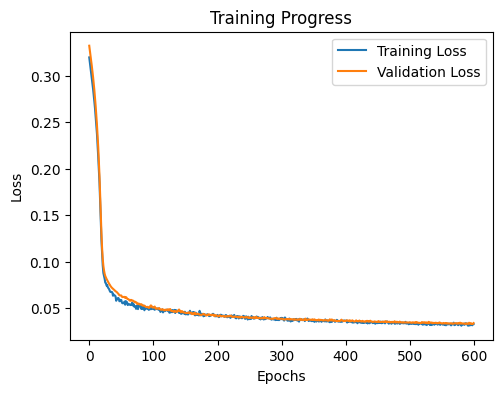

In [64]:
gan_model = MultiModalGNNModel(
    input_dims=network_dimesions)

gan_model = gan_model.to(device)

# criterion for regression task
criterion = nn.L1Loss() 

# Fix 7: Better optimizer settings for this problem
optimizer = optim.Adam(gan_model.parameters(), lr=0.00001, weight_decay=0.0001)  # Lower LR and weight decay

# Initialize early stopping
early_stopper = EarlyStopping(patience=50, min_delta=0.0001, path='model_checkpoints/gan_checkpoint.pt')

# Train the model
epochs = 600
train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, train_loader, val_loader, early_stopper)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gan, label='Training Loss')
plt.plot(val_losses_gan, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, test_loader, device, printing=True):
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for data_dict in test_loader:
            # Move data to device if not already
            data_dict = {k: (v.to(device) if hasattr(v, 'to') else v) for k, v in data_dict.items()}
            output = model(data_dict)
            mask = torch.tensor(data_dict['GINI'].exists, dtype=torch.bool, device=output.device).flatten()
            true = data_dict['GINI'].y[mask].cpu().numpy()
            pred = output[mask].cpu().numpy()
            all_true.append(true)
            all_pred.append(pred)
    # Concatenate results from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Calculate mean percentage error (MPE)
    mpe = np.mean((all_true - all_pred) / all_true) * 100
    # Calculate regression metrics
    mae = mean_absolute_error(all_true, all_pred)
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    r2 = r2_score(all_true, all_pred)

    if printing:
        print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"R^2 Score: {r2:.4f}")

        # Visualization: Predicted vs True
        plt.figure(figsize=(6, 6))
        plt.scatter(all_true, all_pred, alpha=0.5)
        plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
        plt.xlabel('True GINI')
        plt.ylabel('Predicted GINI')
        plt.title('Predicted vs True GINI (Test Set)')
        plt.tight_layout()
        plt.show()

        # Visualization: Residuals
        residuals = all_true - all_pred
        plt.figure(figsize=(6, 4))
        plt.hist(residuals, bins=30, alpha=0.7)
        plt.xlabel('Residual (True - Predicted)')
        plt.ylabel('Frequency')
        plt.title('Residuals Distribution')
        plt.tight_layout()
        plt.show()
    
    return all_true, all_pred

Mean Percentage Error (MPE): -0.07%
Mean Absolute Error (MAE): 0.0321
Root Mean Squared Error (RMSE): 0.0435
R^2 Score: 0.7328


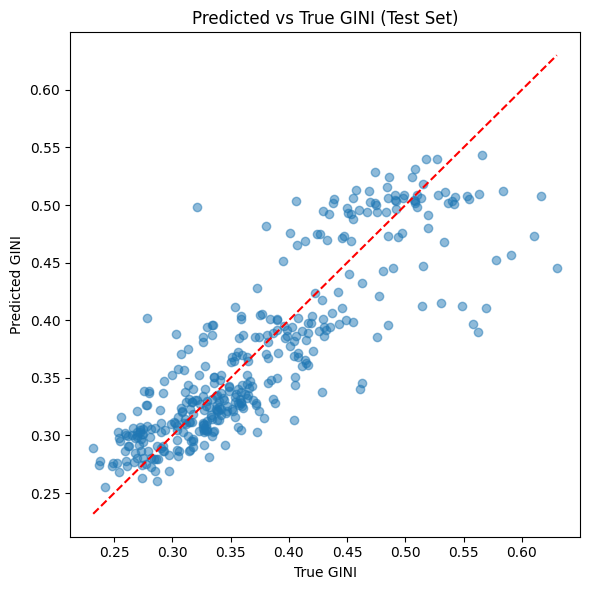

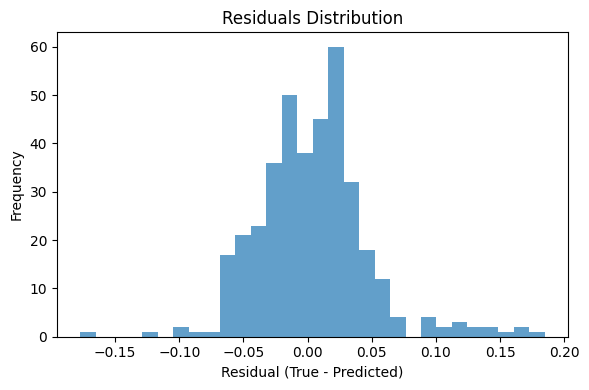

In [68]:
true, pred = evaluate_model(gan_model, test_loader, device)

## Hyperparameter Tuning with Optuna

In [11]:
import optuna

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

train_set = [move_data_dict_to_device(d, device) for d in train_set]
val_set = [move_data_dict_to_device(d, device) for d in val_set]
test_set = [move_data_dict_to_device(d, device) for d in test_set]


def objective(trial):
    
    hidden_size = trial.suggest_int("hidden_size", 20, 300, step=16)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-3, log=True)
    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    
    n_gat_layers = trial.suggest_int("n_gat_layers", 1, 3)
    n_dim_mlp_layers = trial.suggest_int("n_dim_mlp_layers", 0, 3)
    combination_method = trial.suggest_categorical("combination_method", ['concat', 'attention'])
    batch_size = trial.suggest_int("batch_size", 2, 8, step=1)
    
    mlp_variant = trial.suggest_categorical("mlp_variant", ['default', 'deep', 'shallow'])


    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    gan_model = MultiModalGNNModel(
        input_dims=network_dimesions, hidden_size=hidden_size,
        n_gat_layers=n_gat_layers, n_dim_mlp_layers=n_dim_mlp_layers,
        combination_method=combination_method,
        mlp_variant=mlp_variant)
    
    gan_model = gan_model.to(device)
    
    # criterion for regression task
    criterion = MeanAbsolutePercentageError().to(device)
    
    # Fix 7: Better optimizer settings for this problem
    optimizer = optim.Adam(gan_model.parameters(), lr=lr, weight_decay=weight_decay)  # Lower LR and weight decay
    
    # Initialize early stopping
    early_stopper = EarlyStopping(patience=30, min_delta=0.00001, path='model_checkpoints/gan_checkpoint_optuna.pt', printing=False)
    
    # Train the model
    epochs = 600
    train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, train_loader, val_loader, early_stopper, printing=False)
    
    # Evaluate the model on the validation set
    true, pred = evaluate_model(gan_model, val_loader, device, printing =False)
    mape = np.mean(np.abs((true - pred) / np.abs(true))) * 100
    
    return mape

study = optuna.create_study(
    study_name = "Multimodal_base",
    storage="sqlite:///optuna_study_optimized.db",
    direction="minimize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(study.best_trial.params)

[I 2025-08-14 05:29:53,596] A new study created in RDB with name: Multimodal_base
/home/jovyan/environments/dlss_env/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [20, 300] and step=16, but the range is not divisible by `step`. It will be replaced by [20, 292].
  warnings.warn(
[I 2025-08-14 05:31:51,539] Trial 0 finished with value: 10.019634246826172 and parameters: {'hidden_size': 84, 'weight_decay': 0.00011497228852444661, 'lr': 0.0003982638859802879, 'n_gat_layers': 3, 'n_dim_mlp_layers': 2, 'combination_method': 'attention', 'batch_size': 2, 'mlp_variant': 'shallow'}. Best is trial 0 with value: 10.019634246826172.
/home/jovyan/environments/dlss_env/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [20, 300] and step=16, but the range is not divisible by `step`. It will be replaced by [20, 292].
  warnings.warn(
[I 2025-08-14 05:33:44,595] Trial 1 finished with value: 4

Best trial:
{'hidden_size': 148, 'weight_decay': 3.414375524585915e-07, 'lr': 0.0006502342591153078, 'n_gat_layers': 1, 'n_dim_mlp_layers': 0, 'combination_method': 'attention', 'batch_size': 3, 'mlp_variant': 'deep'}


best performance with deep MLP and only 1 GAT layer..... maybe network is not soooo important after all....